In [153]:
import re
import os
import spacy
import zipfile
import pandas as pd
import numpy as np
import spacy
import optuna
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [87]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [88]:
nlp = spacy.load('en_core_web_sm')

In [89]:
train = pd.read_json("train.json")

# Предварительный анализ данных
## Общая информация о датасете

In [90]:
train.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [91]:
train.shape

(39774, 3)

In [92]:
train.isnull().sum()

id             0
cuisine        0
ingredients    0
dtype: int64

Каждая запись включает в себя:
* id
* cuisine: тип кухни (прим. греческая, индийская, филипинская). Целевая переменная.
* список ингридиентов

Количество записей в датасете: 39774

Пропущенные значения отсутствуют.

In [93]:
INGREDIENTS = 75

unique_cuisines = set(train['cuisine'])

all_ingredients_with_cuisine = [
    (cuisine, ingredient)
    for cuisine, ingredients_list in zip(train['cuisine'], train['ingredients'])
    for ingredient in ingredients_list
]

ingredient_counts = Counter([item[1] for item in all_ingredients_with_cuisine])

most_common_ingredients = [item for item, count in ingredient_counts.most_common(INGREDIENTS)]

ingredient_cuisine_distribution = {
    ingredient: len(
        set(cuisine for cuisine, ingr in all_ingredients_with_cuisine if ingr == ingredient)
    )
    for ingredient in most_common_ingredients
}

total_cuisines = len(unique_cuisines)
ingredient_cuisine_ratios = {
    ingredient: (count / total_cuisines) * 100
    for ingredient, count in ingredient_cuisine_distribution.items()
}

sorted_ingredients = sorted(
    ingredient_cuisine_ratios.items(),
    key=lambda x: x[1],
    reverse=True
)

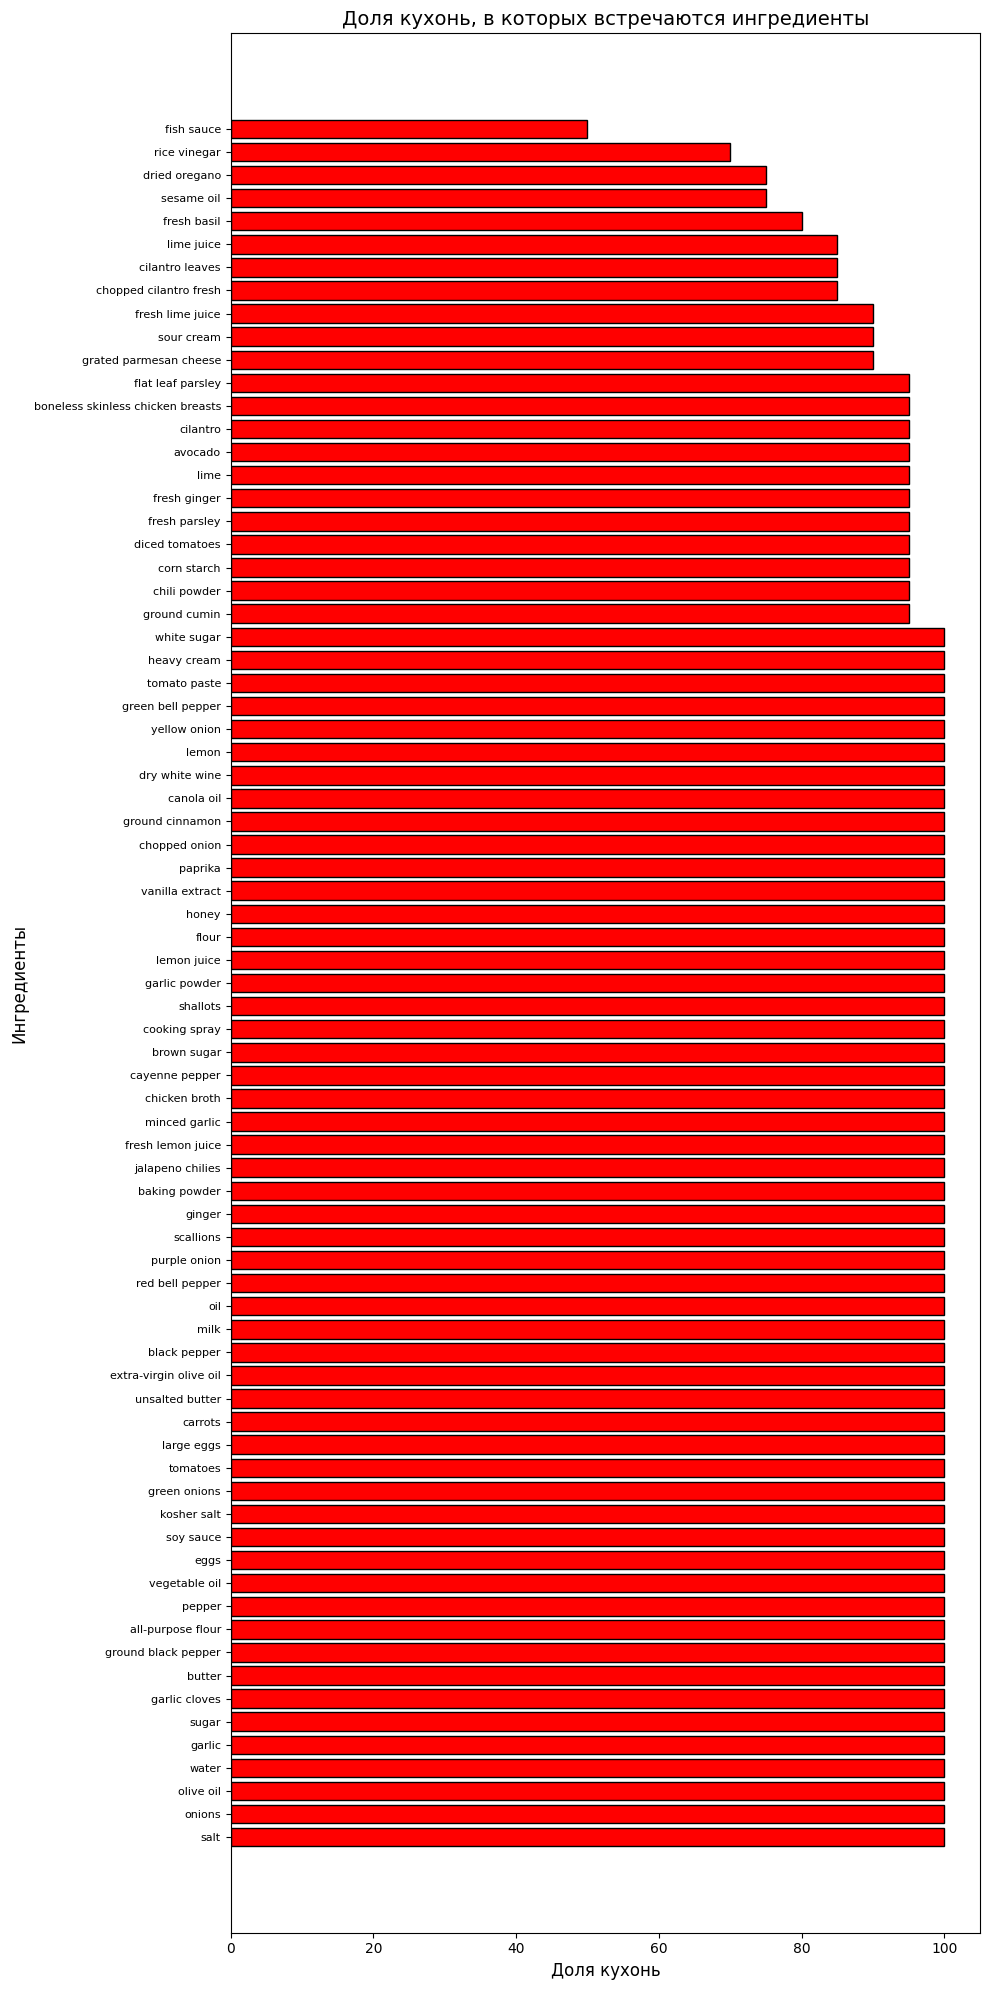

In [94]:
ingredients = [item[0] for item in sorted_ingredients]
ratios = [item[1] for item in sorted_ingredients]

ingredients = ingredients
ratios = ratios

plt.figure(figsize=(10, 20))

plt.barh(ingredients, ratios, color='red', edgecolor='black')

plt.xlabel('Доля кухонь', fontsize=12)
plt.ylabel('Ингредиенты', fontsize=12)
plt.title('Доля кухонь, в которых встречаются ингредиенты', fontsize=14)
plt.yticks(fontsize=8)

plt.tight_layout()
plt.show()

In [95]:
WORDS = 20

all_words = [
    word
    for ingredients in train['ingredients']
    for ingredient in ingredients
    for word in ingredient.split()
]

short_words = [word for word in all_words if len(word) <= 2]

short_word_counts = Counter(short_words)

top_short_words = short_word_counts.most_common(WORDS)

print("Наиболее частые короткие слова:")
for word, count in top_short_words:
    print(f"{word}: {count}")

Наиболее частые короткие слова:
of: 691
in: 413
&: 375
de: 232
1%: 211
2%: 85
or: 63
El: 52
el: 44
on: 30
lo: 29
I: 22
(: 20
no: 19
4: 11
up: 9
'n: 7
-: 6
au: 6
ic: 5


## Предварительный анализ кухонь

In [96]:
cuisines = train['cuisine'].value_counts()
len(cuisines)

20

In [97]:
cuisines

cuisine
italian         7838
mexican         6438
southern_us     4320
indian          3003
chinese         2673
french          2646
cajun_creole    1546
thai            1539
japanese        1423
greek           1175
spanish          989
korean           830
vietnamese       825
moroccan         821
british          804
filipino         755
irish            667
jamaican         526
russian          489
brazilian        467
Name: count, dtype: int64

* Количество кухонь в датасете: 20
* Наиболее встречающаяся кухня - итальянская (7838)
* Наименее встречаюшаяся кухня - бразильская (467)

## Предварительный анализ ингридиентов

In [98]:
unique_ingredients = train['ingredients'].explode().unique()
len(unique_ingredients)

6714

In [99]:
ingredients_per_record = train['ingredients'].apply(len)

In [100]:
ingredients_per_record.min()

np.int64(1)

In [101]:
ingredients_per_record.max()

np.int64(65)

In [102]:
ingredients_per_record.mean()

np.float64(10.76771257605471)

In [103]:
ingredients_per_record.median()

np.float64(10.0)

In [104]:
ingredient_counts = train['ingredients'].explode().value_counts()
ingredient_counts.head(5)

ingredients
salt         18049
olive oil     7972
onions        7972
water         7457
garlic        7380
Name: count, dtype: int64

In [105]:
ingredient_counts.tail(5)

ingredients
reduced sodium ham            1
whole wheat peasant bread     1
ranch-style seasoning         1
ketjap                        1
chocolate flavored liqueur    1
Name: count, dtype: int64

In [106]:
cuisine_ingredients = train.groupby('cuisine')['ingredients'].agg(lambda x: len(set([item for sublist in x for item in sublist]))).sort_values(ascending=False)
cuisine_ingredients

cuisine
italian         2929
mexican         2684
southern_us     2462
french          2102
chinese         1792
indian          1664
cajun_creole    1576
japanese        1439
thai            1376
spanish         1263
greek           1198
british         1166
vietnamese      1108
irish            999
moroccan         974
filipino         947
korean           898
jamaican         877
russian          872
brazilian        853
Name: ingredients, dtype: int64

* Количество различных ингридиентов - 6714
* Минимальное количество ингридиентов для одной записи - 1
* Максимальное количество ингридиентов для одной записи - 65
* Среднее значение ингридиентов для одной записи ~ 10
* Медианное значение ингридиентов для одной записи - 10
* Наиболее встречающийся ингридиент - соль
* Наименее встречающийся игридиент - измельченные сырные крекеры (и еще ~1900)
* Наиболее разнообразная кухня - итальянская
* Наименее разнообразная кухня - бразильская

# Анализ пропущенных значений

In [107]:
empty_id = train['id'].isnull().sum()
empty_cuisine = train['cuisine'].isnull().sum()
empty_ingredients = train['ingredients'].isnull().sum()
empty_ingredients_list = (train['ingredients'].str.len() == 0).sum()

print("Пропущенные ID:", empty_id)
print("Пропущенные типы кухни:", empty_cuisine)
print("Пропущенные списки ингредиентов:", empty_ingredients)
print("Пустые списки ингредиентов:", empty_ingredients_list)

Пропущенные ID: 0
Пропущенные типы кухни: 0
Пропущенные списки ингредиентов: 0
Пустые списки ингредиентов: 0


# Предобработка данных
## Преобразование целевой переменной

In [108]:
label_encoder = LabelEncoder()
train['cuisine_label_encoder'] = label_encoder.fit_transform(train['cuisine'])
train.head(10)

,id,cuisine,ingredients,cuisine_label_encoder
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4
3,22213,indian,"[water, vegetable oil, wheat, salt]",7
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7
5,6602,jamaican,"[plain flour, sugar, butter, eggs, fresh ginge...",10
6,42779,spanish,"[olive oil, salt, medium shrimp, pepper, garli...",17
7,3735,italian,"[sugar, pistachio nuts, white almond bark, flo...",9
8,16903,mexican,"[olive oil, purple onion, fresh pineapple, por...",13
9,12734,italian,"[chopped tomatoes, fresh basil, garlic, extra-...",9


## Преобразование ингредиентов

In [109]:
def preprocess_ingredients(ingredients):
    text = ' '.join(ingredients)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)

    return text

In [110]:
train['preprocess_ingredients'] = train['ingredients'].apply(preprocess_ingredients)

In [111]:
tfidf = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    analyzer="word",
    max_df=0.57,
    binary=False,
    token_pattern=r'\b\w+\b',
    sublinear_tf=False
)

ingredients_tfidf = tfidf.fit_transform(train['preprocess_ingredients'])

ingredients_tfidf_df = pd.DataFrame(
    ingredients_tfidf.toarray(),
    columns=tfidf.get_feature_names_out(),
    index=train.index
)

train_final = pd.concat([train[['id', 'cuisine', 'cuisine_label_encoder']], ingredients_tfidf_df], axis=1)

In [112]:
train_final.head()

,id,cuisine,cuisine_label_encoder,aai,abalone,abbamele,absinthe,abura,acai,accent,...,yuzu,yuzukosho,zaatar,zatarains,zero,zest,zesty,zinfandel,ziti,zucchini
0,10259,greek,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25693,southern_us,16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20130,filipino,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22213,indian,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13162,indian,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [113]:
train_final.shape

(39774, 3024)

# Спринт 4
## BaseLine модель (без обработки признаков)

In [114]:
train['ingredients_text'] = train['ingredients'].apply(lambda x: " ".join(x))
train.head(5)

,id,cuisine,ingredients,cuisine_label_encoder,preprocess_ingredients,ingredients_text
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes...",6,romaine lettuce black olives grape tomatoes ga...,romaine lettuce black olives grape tomatoes ga...
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g...",16,plain flour ground pepper salt tomatoes ground...,plain flour ground pepper salt tomatoes ground...
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g...",4,eggs pepper salt mayonaise cooking oil green c...,eggs pepper salt mayonaise cooking oil green c...
3,22213,indian,"[water, vegetable oil, wheat, salt]",7,water vegetable oil wheat salt,water vegetable oil wheat salt
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe...",7,black pepper shallots cornflour cayenne pepper...,black pepper shallots cornflour cayenne pepper...


In [115]:
X = train['ingredients_text']
y = train['cuisine']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

In [116]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7795534008215819
Recall: 0.7818981772470145
F1 Score: 0.7790061224049661


## BaseLine модель (с обработкой признаков)

In [117]:
X = ingredients_tfidf
y = train['cuisine_label_encoder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [118]:
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.7791219448315985
Recall: 0.7800125707102451
F1 Score: 0.7737955675515317


Результаты без обработки оказались более высокими. Precision (0.779), Recall (0.781) и F1 (0.778).
Результаты с обработкой (очистка текста и использование TfidfVectorizer) получились немного более низкими. Precision (0.773), Recall (0.765) и F1 (0.754).

Это говорит о том, что дополнительная очистка данных и использование TF-IDF не улучшили качество модели.

# Спринт 6
## Обучение с помощью torch

In [119]:
del train

In [120]:
train = pd.read_json("train.json")

In [121]:
train = pd.read_json("train.json")
lemmatizer = WordNetLemmatizer()


def preprocess_ingredients(ingredients):
    
    processed_ingredients = []

    for ingredient in ingredients:
        ingredient = ingredient.lower()
        ingredient = re.sub(r'[^a-zA-Z\s]', '', ingredient)
        
        words = re.split(r'\s+', ingredient.strip())
        
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
        
        ingredient = ' '.join(lemmatized_words)
        ingredient = ingredient.strip()
        processed_ingredients.append(ingredient)

    return processed_ingredients


train["ingredients"] = train["ingredients"].apply(preprocess_ingredients)

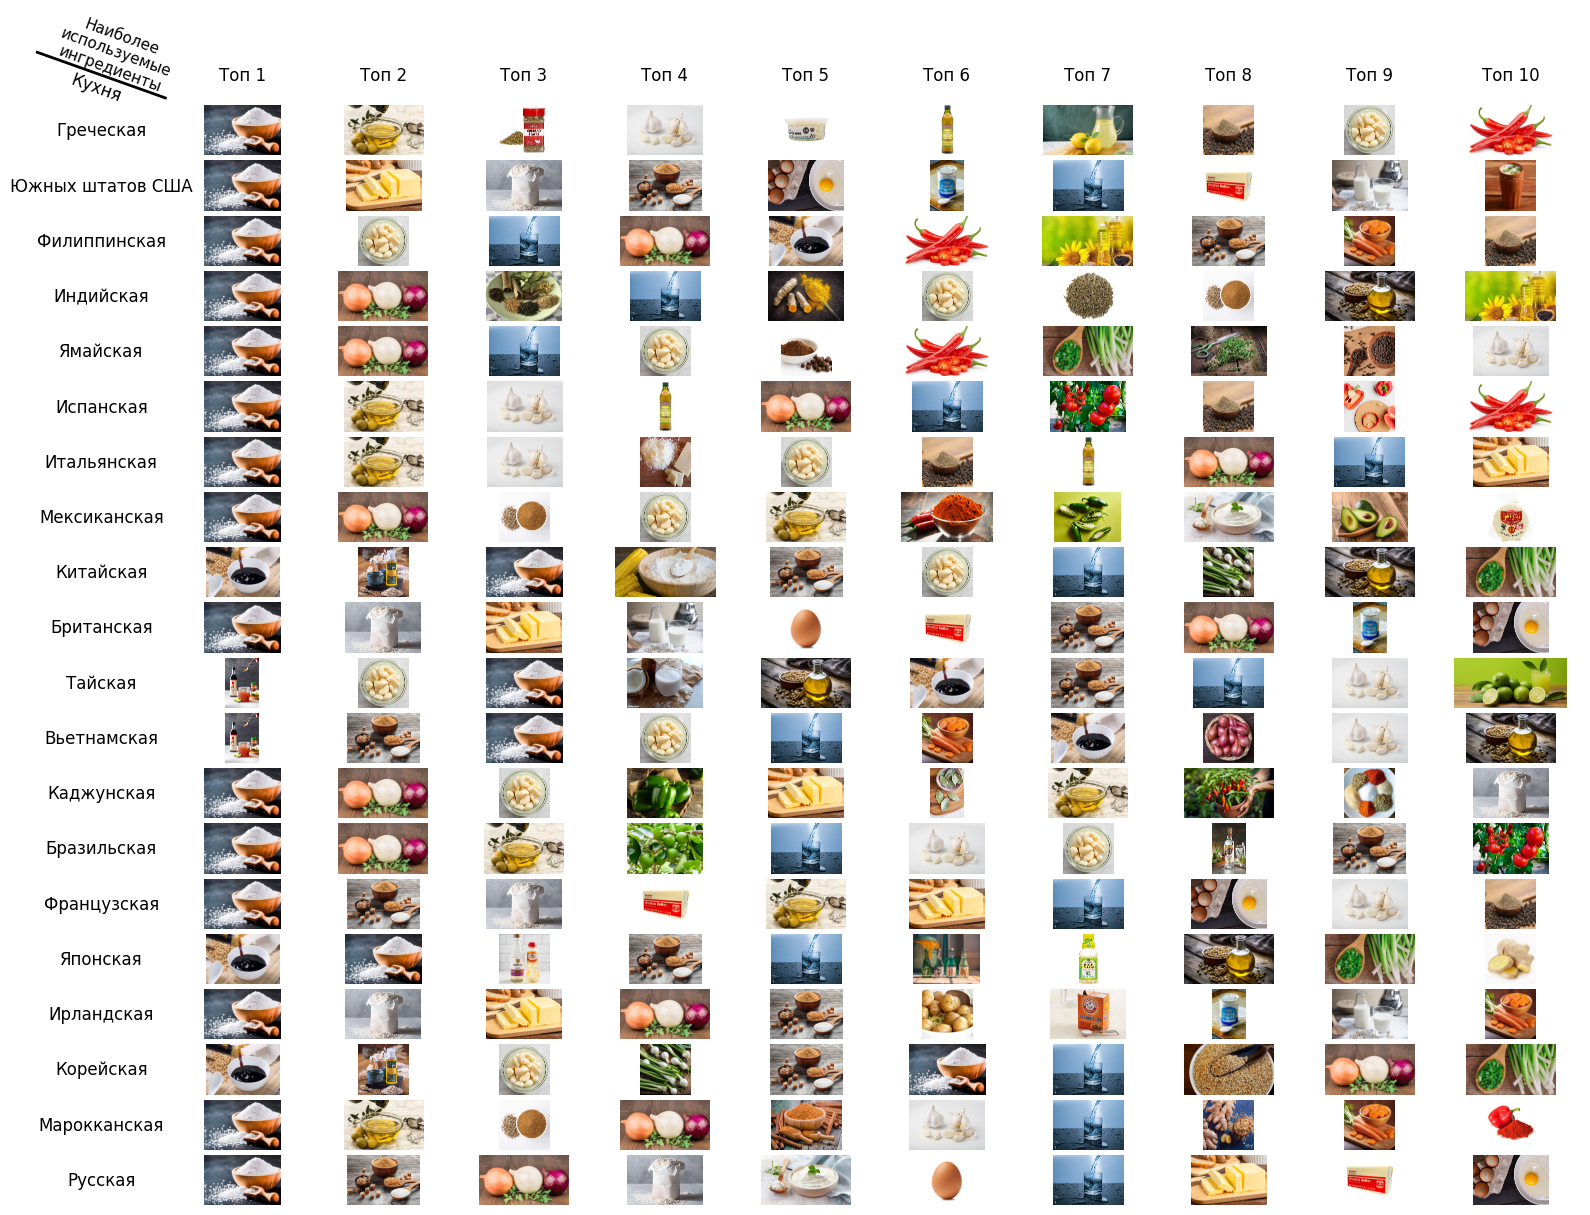

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd


countries = {
    "greek": "Гречeская",
    "southern_us": "Южных штатов США",
    "filipino": "Филиппинская",
    "indian": "Индийская",
    "jamaican": "Ямайская",
    "spanish": "Испанская",
    "italian": "Итальянская",
    "mexican": "Мексиканская",
    "chinese": "Китайская",
    "british": "Британская",
    "thai": "Тайская",
    "vietnamese": "Вьетнамская",
    "cajun_creole": "Каджунская",
    "brazilian": "Бразильская",
    "french": "Французская",
    "japanese": "Японская",
    "irish": "Ирландская",
    "korean": "Корейская",
    "moroccan": "Марокканская",
    "russian": "Русская"
}
counters = {}
for cuisine in train['cuisine'].unique():
    counters[cuisine] = Counter()
    indices = (train['cuisine'] == cuisine)
    for ingredients in train[indices]['ingredients']:
        counters[cuisine].update(ingredients)

top10 = pd.DataFrame([[items[0] for items in counters[cuisine].most_common(10)] for cuisine in counters], index=[countries.get(cuisine, cuisine) for cuisine in counters], columns=['топ{}'.format(i) for i in range(1, 11)])

top10_with_labels = pd.DataFrame(columns=[''] + ['топ{}'.format(i) for i in range(1, 11)])
top10_with_labels[''] = [''] + list(top10.index)

fig, axes = plt.subplots(nrows=len(top10.index) + 1, ncols=len(top10.columns) + 1, figsize=(20, 15), gridspec_kw={'hspace': 0.1, 'wspace': 0})

for col_idx in range(1, len(top10_with_labels.columns)):
    ax = axes[0, col_idx]
    ax.text(0.5, 0.5, f"Топ {col_idx}", fontsize=12, ha='center', va='center', rotation=0)
    ax.axis('off')

for row_idx, cuisine in enumerate(top10.index):
    for col_idx, ingredient in enumerate(top10.loc[cuisine]):
        ax = axes[row_idx + 1, col_idx + 1]
        image_path = f"/home/images/{ingredient}.jpg"
        img = mpimg.imread(image_path)
        ax.imshow(img)
        ax.axis('off')
    
    ax = axes[row_idx + 1, 0]
    ax.text(0.5, 0.5, cuisine, fontsize=12, ha='center', va='center', rotation=0)
    ax.axis('off')

axes[0, 0].axis('off')
axes[0, 0].text(0.3, 0, 'Кухня', fontsize=12, ha='center', va='center', rotation=-20)
axes[0, 0].text(0.5, 1, 'Наиболее\nиспользуемые\nингредиенты', fontsize=11, ha='center', va='center', rotation=-20)
axes[0, 0].plot([-0.3, 1], [1, -0.3], color='black', lw=2)


plt.show()

In [123]:
cv = CountVectorizer(
    analyzer = "word", 
    ngram_range = (1,1),
    binary = True,
    max_df = 0.5,
    min_df=0.0,
    token_pattern=r'(?u)\b\w+\b'
)

new_train = train.drop(["id", "cuisine"], axis=1)
train["ingredients"] = new_train["ingredients"].apply(" ".join)

ingredients_df = pd.DataFrame.sparse.from_spmatrix(
    cv.fit_transform(train.pop('ingredients')), 
    index=train.index, 
    columns=cv.get_feature_names_out()
)

In [124]:
ingredients_df = ingredients_df.drop('cuisine', axis=1)
train = pd.concat([train['cuisine'], ingredients_df], axis=1)

In [125]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(train["cuisine"])
X = train.drop("cuisine", axis=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [126]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")

X_train_numeric = np.array(X_train.values, dtype=np.float32)
X_test_numeric = np.array(X_test.values, dtype=np.float32)
train_data = TensorDataset(torch.from_numpy(X_train_numeric), torch.from_numpy(y_train))
test_data = TensorDataset(torch.from_numpy(X_test_numeric), torch.from_numpy(y_test))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)


class NNModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)
        self.batch_norm3 = nn.BatchNorm1d(128)
        self.batch_norm4 = nn.BatchNorm1d(64)
        self.batch_norm5 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = self.relu(self.batch_norm1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm3(self.fc3(x)))
        x = self.dropout(x)
        x = self.relu(self.batch_norm4(self.fc4(x)))
        x = self.relu(self.batch_norm5(self.fc5(x)))
        x = self.fc6(x)
        return x


input_dim = X_train.shape[1]
output_dim = len(set(y_train))

model = NNModel(input_dim, output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
for epoch in range(30):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Эпоха {epoch + 1}, Loss: {total_loss / len(train_loader):.4f}")

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

Используемое устройство: cuda
Эпоха 1, Loss: 1.3737
Эпоха 2, Loss: 0.9439
Эпоха 3, Loss: 0.8135
Эпоха 4, Loss: 0.7308
Эпоха 5, Loss: 0.6719
Эпоха 6, Loss: 0.6222
Эпоха 7, Loss: 0.5736
Эпоха 8, Loss: 0.5339
Эпоха 9, Loss: 0.4920
Эпоха 10, Loss: 0.4640
Эпоха 11, Loss: 0.4336
Эпоха 12, Loss: 0.4016
Эпоха 13, Loss: 0.3835
Эпоха 14, Loss: 0.3591
Эпоха 15, Loss: 0.3445
Эпоха 16, Loss: 0.3309
Эпоха 17, Loss: 0.3110
Эпоха 18, Loss: 0.3012
Эпоха 19, Loss: 0.2897
Эпоха 20, Loss: 0.2855
Эпоха 21, Loss: 0.2662
Эпоха 22, Loss: 0.2574
Эпоха 23, Loss: 0.2579
Эпоха 24, Loss: 0.2415
Эпоха 25, Loss: 0.2410
Эпоха 26, Loss: 0.2297
Эпоха 27, Loss: 0.2246
Эпоха 28, Loss: 0.2222
Эпоха 29, Loss: 0.2128
Эпоха 30, Loss: 0.2135


In [127]:
print(f"Precision: {precision_score(all_labels, all_preds, average='weighted')}")
print(f"Recall: {recall_score(all_labels, all_preds, average='weighted')}")
print(f"F1 Score: {f1_score(all_labels, all_preds, average='weighted')}")

Precision: 0.7848356356539139
Recall: 0.7808925204274042
F1 Score: 0.7810178583318202


## Обучение с помощью CatBoost

In [129]:
# model = catboost.CatBoostClassifier(task_type="GPU", devices='0')
# model.fit(X_train, y_train)
# y_pred = model.predict(X_test)

NameError: name 'catboost' is not defined

In [ ]:
# print(f"Precision: {precision_score(y_test, y_pred, average='weighted')}")
# print(f"Recall: {recall_score(y_test, y_pred, average='weighted')}")
# print(f"F1 Score: {f1_score(y_test, y_pred, average='weighted')}")

## Обучение с помощью tensorflow

In [131]:
train = pd.read_json("train.json")

In [132]:
label_encoder = LabelEncoder()
train['cuisine_label_encoder'] = label_encoder.fit_transform(train['cuisine'])

In [133]:
train['preprocess_ingredients'] = train['ingredients'].apply(preprocess_ingredients)

In [134]:
train['ingredients_text'] = train['ingredients'].apply(lambda x: " ".join(x))

In [135]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['preprocess_ingredients'])
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(train['preprocess_ingredients'])
X = pad_sequences(X)
y = train['cuisine_label_encoder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy[1]}")

Epoch 1/10


c:\Users\matve\PycharmProjects\for_tests\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


895/895 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.3626 - loss: 2.1480 - val_accuracy: 0.6383 - val_loss: 1.2348
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6502 - loss: 1.1606 - val_accuracy: 0.6867 - val_loss: 1.0763
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7090 - loss: 0.9565 - val_accuracy: 0.7024 - val_loss: 1.0263
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7496 - loss: 0.8138 - val_accuracy: 0.7090 - val_loss: 1.0200
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7740 - loss: 0.7261 - val_accuracy: 0.7153 - val_loss: 1.0162
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7916 - loss: 0.6773 - val_accuracy: 0.7168 - val_loss: 1.0564
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8110 - loss: 0.6111 - val_accuracy: 0.7203 - val_loss: 1.0947
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8220 - loss: 0.5721 - val_accuracy: 0.7049 - val_

In [136]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: 0.7055047002522867
Recall: 0.7103708359522313
F1 Score: 0.7040146682291866


## Эксперимент (кодировка целевой переменной с помощью OneHotEncoder)

In [137]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['ingredients_text'])
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(train['ingredients_text'])
X = pad_sequences(X, maxlen=100)
y = pd.get_dummies(train['cuisine']).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential([
    Embedding(input_dim=len(word_index) + 1, output_dim=128, input_length=100),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.5),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)

accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy[1]}")

Epoch 1/10


c:\Users\matve\PycharmProjects\for_tests\env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


895/895 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.3825 - loss: 2.0719 - val_accuracy: 0.6565 - val_loss: 1.1391
Epoch 2/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.6565 - loss: 1.1423 - val_accuracy: 0.7062 - val_loss: 0.9772
Epoch 3/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7032 - loss: 0.9714 - val_accuracy: 0.7250 - val_loss: 0.9254
Epoch 4/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7316 - loss: 0.8763 - val_accuracy: 0.7366 - val_loss: 0.8959
Epoch 5/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7534 - loss: 0.8201 - val_accuracy: 0.7508 - val_loss: 0.8943
Epoch 6/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7654 - loss: 0.7656 - val_accuracy: 0.7568 - val_loss: 0.8821
Epoch 7/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7804 - loss: 0.7162 - val_accuracy: 0.7524 - val_loss: 0.8835
Epoch 8/10
895/895 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7889 - loss: 0.6830 - val_accuracy: 0.7524 - val_

In [138]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

precision = precision_score(y_test_labels, y_pred, average='weighted')
recall = recall_score(y_test_labels, y_pred, average='weighted')
f1 = f1_score(y_test_labels, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision: 0.7433055904827404
Recall: 0.7489629164047769
F1 Score: 0.7437551540871801


# Спринт 7
## Обучение модели с помощью метода "Случайный лес"

In [139]:
X = ingredients_tfidf
y = train['cuisine_label_encoder']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [140]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [141]:
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"F1 Score: {f1_rf}")

Precision: 0.7649858451089742
Recall: 0.7508485229415462
F1 Score: 0.7378231924355664


## Optana
## Попытка подбора лучших параметров для RandomForestClassifier с помощью Optana (не хватило памяти)

In [ ]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 50, 300)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
#     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
#     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

#     model = RandomForestClassifier(
#         n_estimators=n_estimators,
#         max_depth=max_depth,
#         min_samples_split=min_samples_split,
#         min_samples_leaf=min_samples_leaf,
#         max_features=max_features,
#         random_state=42,
#         n_jobs=-1
#     )
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
    
#     return f1_score(y_test, y_pred, average='weighted')

In [ ]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=50)
# print("Best parameters:", study.best_params)

In [ ]:
# best_params = study.best_params
# optimized_rf = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
# optimized_rf.fit(X_train, y_train)
# y_pred_optimized = optimized_rf.predict(X_test)

In [ ]:
# precision_opt = precision_score(y_test, y_pred_optimized, average='weighted')
# recall_opt = recall_score(y_test, y_pred_optimized, average='weighted')
# f1_opt = f1_score(y_test, y_pred_optimized, average='weighted')

# print("\nOptimized Random Forest Classifier Metrics:")
# print(f"Precision: {precision_opt}")
# print(f"Recall: {recall_opt}")
# print(f"F1-Score: {f1_opt}")

## Метод опорных векторов + TFIDF

In [142]:
X = ingredients_tfidf
y = train['cuisine_label_encoder']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [144]:
y_pred = model.predict(X_test)

In [145]:
precision_svc = precision_score(y_test, y_pred, average='weighted')
recall_svc = recall_score(y_test, y_pred, average='weighted')
f1_svc = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

Precision: 0.7890446728348931
Recall: 0.788686360779384
F1 Score: 0.7845907682421956


## Попытка подбора лучших параметров для SVC с помощью GridSearchCV (не хватило памяти)

In [ ]:
# X = ingredients_tfidf
# y = train['cuisine_label_encoder']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# param_grid = {
#     'C': [0.1, 1, 10, 100],            
#     'kernel': ['linear', 'rbf', 'poly'], 
#     'gamma': ['scale', 'auto'],         
#     'degree': [2, 3, 4]                 
# }


# svc = SVC(random_state=42)


# grid_search = GridSearchCV(
#     estimator=svc,
#     param_grid=param_grid,
#     scoring='f1_weighted',
#     cv=5,             
#     verbose=1,
#     n_jobs=-1
# )


# grid_search.fit(X_train, y_train)

# print("Лучшие параметры:", grid_search.best_params_)

# best_model = grid_search.best_estimator_
# y_pred = best_model.predict(X_test)

# precision_svc = precision_score(y_test, y_pred, average='weighted')
# recall_svc = recall_score(y_test, y_pred, average='weighted')
# f1_svc = f1_score(y_test, y_pred, average='weighted')

# print(f"Precision: {precision_svc}")
# print(f"Recall: {recall_svc}")
# print(f"F1 Score: {f1_svc}")

## Метод опорных векторов (без обработки ингридиентов)

In [146]:
X = train['ingredients_text']
y = train['cuisine']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [148]:
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(X_train_vec, y_train)

SVC(kernel='linear', random_state=42)

In [149]:
y_pred = model.predict(X_test_vec)

In [150]:
precision_svc = precision_score(y_test, y_pred, average='weighted')
recall_svc = recall_score(y_test, y_pred, average='weighted')
f1_svc = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision_svc}")
print(f"Recall: {recall_svc}")
print(f"F1 Score: {f1_svc}")

Precision: 0.7694008103076989
Recall: 0.7705845380263985
F1 Score: 0.7683858190662124


## Стекинг

In [154]:
estimators = [('lr', LogisticRegression(max_iter=1000)), ('dt', DecisionTreeClassifier())]
modelClf = StackingClassifier(estimators=estimators, final_estimator=SVC())

X = ingredients_tfidf
y = train['cuisine']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)
# 0,78, 10 минут
modelClf.fit(X_train, y_train)

y_pred = modelClf.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f"Точность модели: {accuracy:.2f}")

precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')
f1 = f1_score(y_valid, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print(f'Model Score: {modelClf.score(X_valid, y_valid)}')

Точность модели: 0.78
Precision: 0.7826609493786845
Recall: 0.7834576384815218
F1 Score: 0.7785872060494738
Model Score: 0.7834576384815218


## Бэггинг

In [155]:
modelClf_bagging = BaggingClassifier(estimator=LogisticRegression(max_iter=1000), n_estimators=50, random_state=12)

X = ingredients_tfidf
y = train['cuisine']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=12)
# 1ч 20 минут, 0,78
modelClf_bagging.fit(X_train, y_train)

y_pred = modelClf_bagging.predict(X_valid)

accuracy = accuracy_score(y_valid, y_pred)
print(f"Точность модели: {accuracy:.2f}")

precision = precision_score(y_valid, y_pred, average='weighted')
recall = recall_score(y_valid, y_pred, average='weighted')
f1 = f1_score(y_valid, y_pred, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print(f'Model Score: {modelClf_bagging.score(X_valid, y_valid)}')

Точность модели: 0.78
Precision: 0.7820564226558253
Recall: 0.7812788066705774
F1 Score: 0.7749152014351354
Model Score: 0.7812788066705774
